In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scprep
from tqdm import tqdm
import os
import sys

sys.path.append('../src')
from models.distance_matching import DistanceMatching
from data_script import hemisphere_data, sklearn_swiss_roll

/Users/danqiliao/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Data
data_name = 'swiss_roll'
if data_name == 'swiss_roll':
    gt_X, X, _ = sklearn_swiss_roll(n_samples=1000, noise=0.0)
    colors = None
elif data_name == 'hemisphere':
    gt_X, X, _ = hemisphere_data(n_samples=1000, noise=0.0)
    colors = None

print(gt_X.shape, X.shape)

(1000, 3) (1000, 3)


In [4]:
mode = 'encoder'
model_hypers = {
    'ambient_dimension': 3,
    'latent_dimension': 2,
    'model_type': 'distance',
    'activation': 'relu',
    'layer_widths': [256, 128, 64],
    'knn': 10,
    't': 'auto',
    'n_landmark': 5000,
    'verbose': False
}
training_hypers = {
    'data_name': f'{data_name}',
    'mode': mode, # 'encoder', 'decoder', 'end2end', 'separate
    'max_epochs': 1,
    'batch_size': 64,
    'lr': 1e-3,
    'shuffle': True,
    'componentwise_std': False,
    'weight_decay': 1e-5,
    'dist_mse_decay': 1e-5,
    'monitor': 'validation/loss',
    'patience': 100,
    'seed': 2024,
    'log_every_n_steps': 100,
    'accelerator': 'auto',
    'train_from_scratch': False,
    'model_save_path': f'./{data_name}_distance_matching_{mode}/model'
}

model = DistanceMatching(**model_hypers)
model.fit(X, train_mask=None, percent_test=0.2, **training_hypers)

Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 0.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...


/Users/danqiliao/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 2.10 seconds.
Calculated PHATE in 2.54 seconds.
Fitting model ... {'dimensions': {'data': 3, 'latent': 2}, 'encoder': {'layer_widths': [256, 128, 64], 'activation': 'relu', 'batch_norm': False, 'dropout': 0.0}, 'decoder': {'layer_widths': [64, 128, 256], 'activation': 'relu', 'batch_norm': False, 'dropout': 0.0}, 'loss': {'dist_mse_decay': 1e-05, 'weights': {'dist': 0.9, 'reconstr': 0.1, 'cycle': 0.0, 'cycle_dist': 0.0}}, 'training': {'mode': 'encoder', 'max_epochs': 1, 'accelerator': 'auto', 'lr': 0.001, 'weight_decay': 1e-05, 'dist_mse_decay': 1e-05, 'monitor': 'validation/loss', 'patience': 100, 'log_every_n_steps': 100}, 'logger': {'use_wandb': False}, 'path': {'root': './swiss_roll_distance_matching_encoder', 'model': 'model', 'log': 'mylogs'}}


/Users/danqiliao/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


Loaded encoder from ./swiss_roll_distance_matching_encoder/model, skipping encoder training ...
Loaded decoder from ./swiss_roll_distance_matching_encoder/model, skipping decoder training ...


In [5]:
Z = model.encode(torch.Tensor(X))
print('Encoded Z:', Z.shape)
X_hat = model.decode(Z)
print('Decoded X:', X_hat.shape)

Encoded Z: torch.Size([1000, 2])
Decoded X: torch.Size([1000, 3])


<Axes3D: title={'center': 'Original'}>

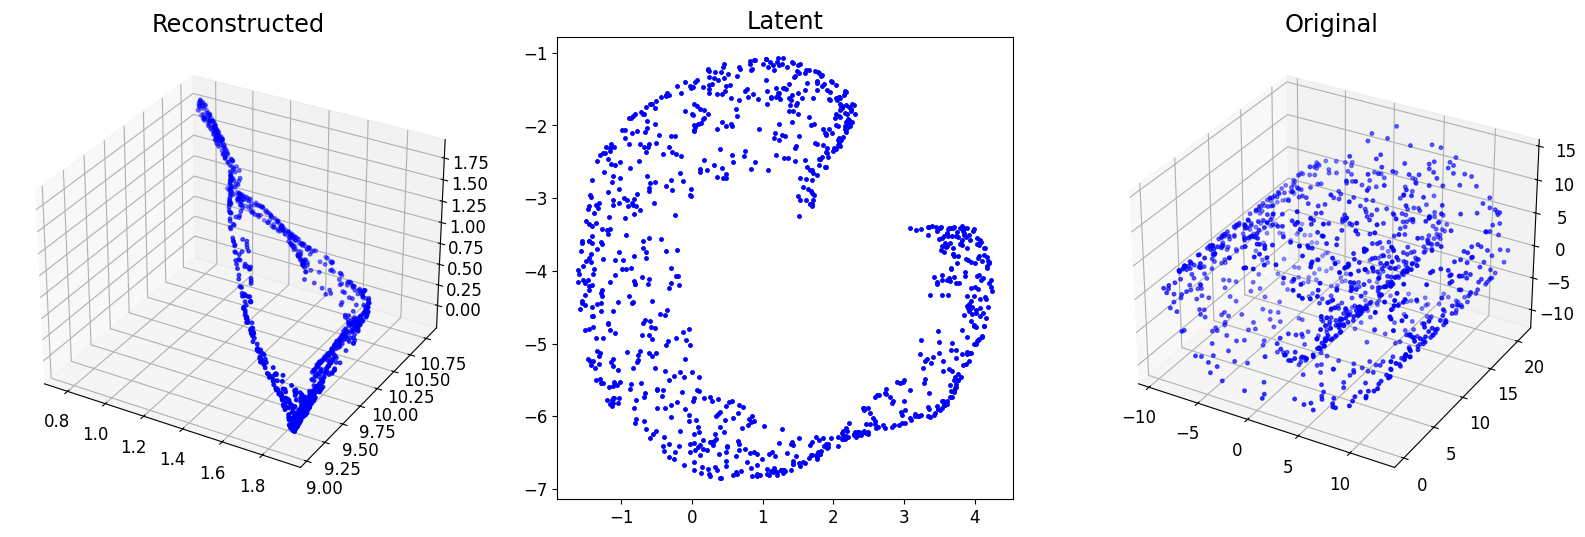

In [6]:
# Visualize
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(131, projection='3d')
scprep.plot.scatter3d(X_hat.detach().numpy(), c='b', title='Reconstructed', ax=ax)

if Z.shape[-1] < 3:
    ax = fig.add_subplot(132)
    scprep.plot.scatter2d(Z.detach().numpy(), c='b', title='Latent', ax=ax)
else:
    ax = fig.add_subplot(132, projection='3d')
    scprep.plot.scatter3d(Z.detach().numpy(), c='b', title='Latent', ax=ax)

ax = fig.add_subplot(133, projection='3d')
scprep.plot.scatter3d(X, c='b', title='Original', ax=ax)

In [ ]:
metric = model.encoder_pullback(torch.Tensor(X))
print('Encoder Pullback:', metric.shape)

z_start: (3,)
z_end: (32, 3)
batch_x0: torch.Size([32, 3])
batch_x1: torch.Size([32, 3])


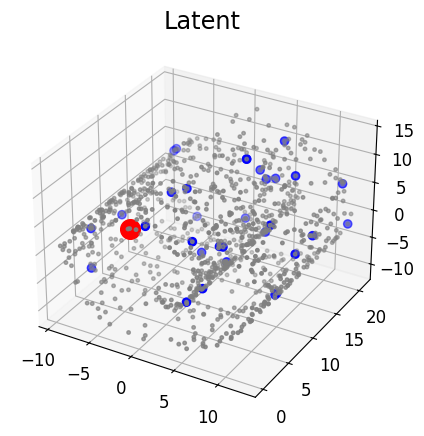

In [22]:
# randomly pick a pair of points in ambient space
def random_pair(Z, num_endpoints=32):
    if isinstance(Z, torch.Tensor):
        Z = Z.detach().numpy()
    z_start = Z[np.random.randint(0, Z.shape[0]), :]
    z_end = Z[np.random.randint(0, Z.shape[0], num_endpoints), :]
    print('z_start:', z_start.shape)
    print('z_end:', z_end.shape)

    batch_x0 = torch.Tensor(np.repeat(z_start.reshape(1, -1), num_endpoints, axis=0))
    batch_x1 = torch.Tensor(z_end)
    print('batch_x0:', batch_x0.shape)
    print('batch_x1:', batch_x1.shape)

    return z_start, z_end, batch_x0, batch_x1

# Z = Z.detach().cpu().numpy()
# X = X.detach().cpu().numpy()
z_start, z_end, batch_x0, batch_x1 = random_pair(X, num_endpoints=32)

dataset = torch.utils.data.TensorDataset(batch_x0, batch_x1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

# Visualize x0, x1 in latent space
fig = plt.figure(figsize=(5, 5))
if z_end.shape[1] < 3:
    ax = fig.add_subplot(111)
    scprep.plot.scatter2d(Z, c='gray', title='Latent', ax=ax)
    scprep.plot.scatter2d(z_start.reshape(1, -1), c='red', ax=ax)
    scprep.plot.scatter2d(z_end, c='blue', ax=ax)
else:
    ax = fig.add_subplot(111, projection='3d')
    scprep.plot.scatter3d(X, c='gray', title='Latent', ax=ax)
    scprep.plot.scatter3d(z_start.reshape(1, -1), c='red', ax=ax)
    scprep.plot.scatter3d(z_end, c='blue', ax=ax)

In [23]:
import torch
from geodesic import CondCurve

curve = CondCurve(input_dim=3, hidden_dim=16, scale_factor=1.0, num_layers=2, symmetric=True)
ts = torch.linspace(0, 1, 100)
path = curve(batch_x0, batch_x1, ts) # [T, B, D]
print(path.shape)

torch.Size([100, 32, 3])


In [24]:
import torch
from torch.autograd import grad

def my_velocity(cc, ts, x0s, x1s):
    '''
    Using jacobian matrix to calculate the velocity
    Args:
        cc: CondCurve module
        ts: torch.Tensor, [T]
        x0: torch.Tensor, [B, D]
        x1: torch.Tensor, [B, D]
    Output:
        velocities: torch.Tensor, [T, B, D]
    '''
    jac = torch.zeros(len(ts), x0s.size(0), x0s.size(1))
    T = len(ts)

    for i in range(T):
        t = ts[i]
        cc_given_x0_x1 = lambda t: cc(x0s, x1s, t) # [1] -> [B, D]
        t = t.unsqueeze(0)
        J = torch.autograd.functional.jacobian(cc_given_x0_x1, t, create_graph=True) # [B, D, 1]
        J = J.squeeze(-1) # [B, D]
        jac[i, :, :] = J

    return jac

def velocity(cc, ts, x0, x1):
    '''
    Args:
        cc: CondCurve module
        ts: torch.Tensor, [T]
        x0: torch.Tensor, [B, D]
        x1: torch.Tensor, [B, D]
    Output:
        velocities: torch.Tensor, [T, B, D]
    '''
    tsc = ts.clone()
    tsc.requires_grad_(True)
    out = cc(x0, x1, tsc)

    orig_shape = out.size()
    out = out.flatten(1,2) # [T, B*D]

    jacobian = torch.zeros(*out.size()).to(tsc.device)
    jac = torch.zeros(*out.size()).to(tsc.device)

    for i in range(out.size(1)):
        grad_outputs = torch.zeros(*out.size()).to(tsc.device)
        grad_outputs[:, i] = 1.0
        #temp = grad(outputs=out, inputs=tsc, grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
        #print(temp.shape)

        jac[:,i] = grad(outputs=out, inputs=tsc, grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    jac = jac.reshape(*orig_shape)
    return jac

import time 

start_t = time.time()
velocities = velocity(curve, ts, batch_x0, batch_x1)
end_t = time.time()
print('Velocity computation time:', end_t - start_t)
print(velocities.shape) # [T, B, D]

Velocity computation time: 0.20920300483703613
torch.Size([100, 32, 3])


In [11]:
def compute_jacobian_function(f, x, create_graph=True, retain_graph=True):
    """
    Compute the Jacobian of the decoder wrt a batch of points in the latent space using an efficient broadcasting approach.
    :param model: The VAE model.
    :param z_batch: A batch of points in the latent space (tensor).
    :return: A batch of Jacobian matrices. 
    """
    x = x.clone()
    x.requires_grad_(True)

    output = f(x)
    batch_size, output_dim, input_dim = *output.shape, x.shape[-1]

    # Use autograd's grad function to get gradients for each output dimension
    jacobian = torch.zeros(batch_size, output_dim, input_dim).to(x.device)
    for i in range(output_dim):
        grad_outputs = torch.zeros(batch_size, output_dim).to(x.device)
        grad_outputs[:, i] = 1.0
        # Vector-Jacobian product: J^T * v, J^T : [input_dim, bacth_size * output_dim], v : [batch_size * output_dim]
        gradients = grad(outputs=output, inputs=x, grad_outputs=grad_outputs, create_graph=create_graph, retain_graph=retain_graph)[0]
        #print(gradients.shape)
        jacobian[:, i, :] = gradients
    return jacobian

In [12]:
jac = compute_jacobian_function(model.encoder, torch.rand(10, 3))
print(jac.shape)

torch.Size([10, 2, 3])


In [25]:
from geodesic import CondCurve
import pytorch_lightning as pl

class GeodesicBridge(pl.LightningModule):
    def __init__(self,
                 func,
                 input_dim,
                 hidden_dim,
                 scale_factor,
                 symmetric,
                 num_layers,
                 lr,
                 weight_decay,
                 n_tsteps=1000,
                 lambda_length=1.0,
                 lambda_density=1.0,
                 density_dataset=None):
        super(GeodesicBridge, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.scale_factor = scale_factor
        self.symmetric = symmetric
        self.num_layers = num_layers
        self.lr = lr
        self.weight_decay = weight_decay
        self.func = func
        
        self.func.requires_grad_(False)

        self.cc = CondCurve(input_dim=input_dim,
                            hidden_dim=hidden_dim,
                            scale_factor=scale_factor,
                            symmetric=symmetric,
                            num_layers=num_layers)

        self.ts = torch.linspace(0, 1, n_tsteps)
        # self.register_buffer("t", ts)

        self.lambda_density = lambda_density
        self.lambda_length = lambda_length
        if isinstance(density_dataset, torch.Tensor) is False:
            density_dataset = torch.Tensor(density_dataset)
        self.density_dataset = density_dataset

    def forward(self, x0, x1, t):
        return self.cc(x0, x1, t)
    
    def density_loss(self, x_t_flat, data_pts, n_topk=5):
        '''
            x_t_flat: [T*B, D]
            data_pts: [N, D]

            return: loss
        '''
        vals, inds = torch.topk(
            torch.cdist(x_t_flat, data_pts), k=n_topk, dim=-1, largest=False, sorted=False
        )

        return vals.mean()

    def length_loss(self, vectors_flat, jac_flat):
        return torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1)).mean()
        # loss = torch.sqrt(torch.square(jac_flat @ vectors_flat).sum(axis=1)).mean()

    def step(self, batch, batch_idx):
        x0, x1 = batch # [B, D]
        vectors = velocity(self.cc, self.ts, x0, x1) # [T, B, D]
        cc_pts = self.cc(x0, x1, self.ts) # [T, B, D]

        vectors_flat = vectors.flatten(0,1) # [T*B, D]
        cc_pts_flat = cc_pts.flatten(0, 1) # [T*B, D]

        jac_flat = compute_jacobian_function(self.func, cc_pts_flat) # [T*B, n, D]; func: R^D -> R^n
        length_loss = self.length_loss(vectors_flat, jac_flat)
        density_loss = 0.0

        if self.lambda_density > 0:
            density_loss = self.density_loss(cc_pts_flat, self.density_dataset)
        
        loss = length_loss * self.lambda_length + density_loss * self.lambda_density

        #print('length_loss:', length_loss, 'density_loss:', density_loss)

        return loss, length_loss, density_loss

    def training_step(self, batch, batch_idx):
        loss, length_loss, density_loss = self.step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('train_length_loss', length_loss, prog_bar=True, on_epoch=True)
        self.log('train_density_loss', density_loss, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, length_loss, density_loss = self.step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_length_loss', length_loss, prog_bar=True, on_epoch=True)
        self.log('val_density_loss', density_loss, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, length_loss, density_loss= self.step(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_length_loss', length_loss, prog_bar=True, on_epoch=True)
        self.log('test_density_loss', density_loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [15]:
length_lambda = 1.0
density_lambda = 100.0
bridge = GeodesicBridge(func=model.encoder,
                         input_dim=3,
                         hidden_dim=64,
                         scale_factor=1,
                         symmetric=False,
                         num_layers=3,
                         lr=1e-3,
                         weight_decay=1e-5,
                         n_tsteps=1000,
                         lambda_length=length_lambda,
                         lambda_density=density_lambda,
                         density_dataset=X)
trainer = pl.Trainer(max_epochs=1000, gpus=0)
trainer.fit(bridge, dataloader)

/Users/danqiliao/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type      | Params
-----------------------------------
0 | func | Encoder   | 42.3 K
1 | cc   | CondCurve | 42.3 K
-----------------------------------
42.3 K    Trainable params
42.3 K    Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, loss=101, v_num=56, train_loss_step=108.0, train_length_loss_step=9.430, train_density_loss_step=0.986, train_loss_epoch=96.80, train_length_loss_epoch=8.770, train_density_loss_epoch=0.880] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, loss=101, v_num=56, train_loss_step=108.0, train_length_loss_step=9.430, train_density_loss_step=0.986, train_loss_epoch=96.80, train_length_loss_epoch=8.770, train_density_loss_epoch=0.880]


In [16]:
# Visualize
n_samples = 10
t = torch.linspace(0, 1, 1000).view(-1,1)
pred_geodesic = bridge(batch_x0[:n_samples, :], batch_x1[:n_samples, :], t).detach().numpy()
print('Pred Geodesic:', pred_geodesic.shape)

Pred Geodesic: (1000, 10, 3)


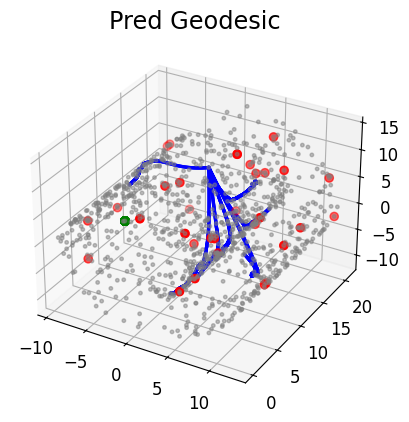

In [26]:
fig = plt.figure()
D = pred_geodesic.shape[-1]
pred_geodesic = pred_geodesic.reshape(-1, D)
# Visualize pred geodesic on the ambient space
if pred_geodesic.shape[-1] < 3:
    ax = fig.add_subplot(111)
    scprep.plot.scatter2d(X, c='gray', ax=ax)
    scprep.plot.scatter2d(batch_x0.detach().numpy(), c='g', ax=ax, alpha=0.5)
    scprep.plot.scatter2d(batch_x1.detach().numpy(), c='r', ax=ax)
    scprep.plot.scatter2d(pred_geodesic, c='b', title='Pred Geodesic', ax=ax)
else:
    ax = fig.add_subplot(111, projection='3d')
    scprep.plot.scatter3d(X, c='gray', ax=ax, alpha=0.5)
    scprep.plot.scatter3d(batch_x0.detach().numpy(), c='g', ax=ax)
    scprep.plot.scatter3d(batch_x1.detach().numpy(), c='r', ax=ax)
    scprep.plot.scatter3d(pred_geodesic, c='b', title='Pred Geodesic', ax=ax)

    # anmi = scprep.plot.rotate_scatter3d(X, c='gray', ax=ax, alpha=0.5)
    # anmi = scprep.plot.rotate_scatter3d(batch_x0.detach().numpy()[:n_samples,:], c='g', ax=ax)
    # anmi = scprep.plot.rotate_scatter3d(batch_x1.detach().numpy()[:n_samples,:], c='r', ax=ax)
    # anmi = scprep.plot.rotate_scatter3d(pred_geodesic, c='b', title='Pred Geodesic', ax=ax)

    #anmi.save(f'density{density_lambda}_{data_name}_geodesic.gif', writer='imagemagick', fps=60)

plt.show()

In [18]:
# Plotly 3D scatter plot
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2], mode='markers', marker=dict(size=5, color='gray', opacity=0.5)))
fig.add_trace(go.Scatter3d(x=batch_x0[:n_samples,0], y=batch_x0[:,1], z=batch_x0[:,2], mode='markers', marker=dict(size=5, color='red')))
fig.add_trace(go.Scatter3d(x=batch_x1[:n_samples,0], y=batch_x1[:,1], z=batch_x1[:,2], mode='markers', marker=dict(size=5, color='green')))
fig.add_trace(go.Scatter3d(x=pred_geodesic[:,0], y=pred_geodesic[:,1], z=pred_geodesic[:,2], mode='markers', marker=dict(size=5, color='blue')))

# save
fig.write_html(f'density{density_lambda}_{data_name}_geodesic.html')

### With Density Loss